## Simulated data generation

In this notebook we showcase 
- how to generate spatial transcriptomics data
- how to use the generated data for downstream tasks.

We adapted the code for data simulation from https://github.com/AltschulerWu-Lab/MUSE/tree/master/simulation_tool and added spatial modality by sorting the spots in spatial space. You can find the adapted version [here](https://github.com/ratschlab/simulate_spatial_transcriptomics_tool). https://github.com/ratschlab/simulate_spatial_transcriptomics_tool

> We adapted the simulation approach suggested in [5] by introducing spatial structure in the experiment. Briefly, relying on simulated ground truth labels, we simulate transcriptomics and morphology modalities, allowing partial observation of true clusters within each modality individually. However, combining both modalities enables the identification of all clusters. Spatial coordinates are incorporated by sorting the ground truth in spatial space.

Please refer to our original publication for more information and examples.

In [1]:
from src.simulate_st_data import generate_samples
import numpy as np
np.random.seed(2023)


    Parameters:
          main_dir          folder where to save outputs.
          sample_names      list with string names of adatas.
          n_clusters:       number of ground truth clusters.
          n_points:         number of cells to simulate.
          n_components:     Number of components to keep.
          d_1:              dimension of features for transcript modality.
          d_2:              dimension of features for morphological modality.
          k:                dimension of latent code to generate simulate data (for both modality)
          sigma_1:          variance of gaussian noise for transcript modality.
          sigma_2:          variance of gaussian noise for morphological modality.
          decay_coef_1:     decay coefficient of dropout rate for transcript modality.
          decay_coef_2:     decay coefficient of dropout rate for morphological modality.
          merge_prob:       probability to merge neighbor clusters for the generation of modality-specific
                            clusters (same for both modalities)

Here, we generate two tissue slices A and B with 1000 spots and 500 genes (default). The data will contain 5 ground truth clusters.

32 32
A created...
32 32
B created...


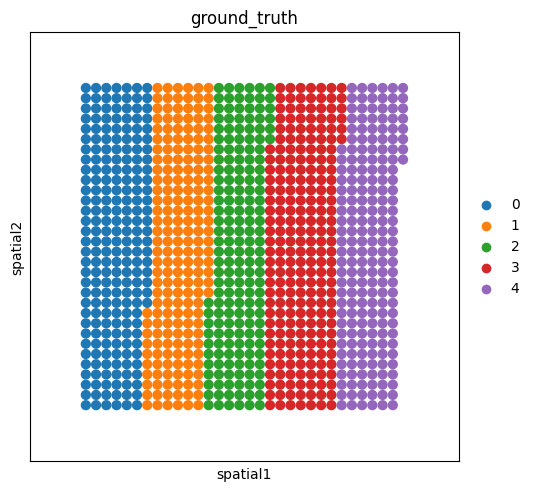

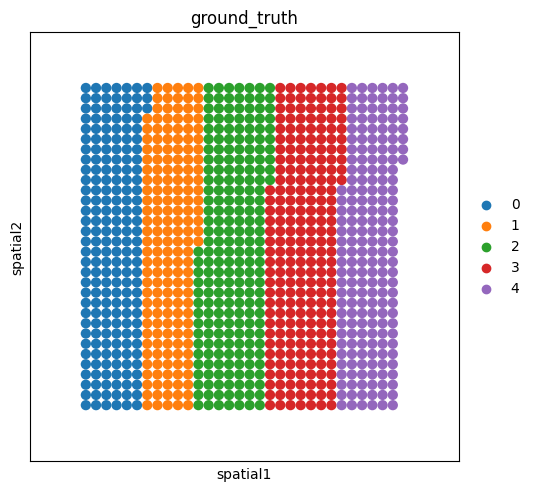

In [2]:
main_folder = "example_data"
sample_names = ["A", "B"]
generate_samples(main_folder, 
                 sample_names, 
                 n_clusters=5, 
                 n_points=1000)

Now, we will load the data using scanpy, perform clustering and visualize the results.

In [3]:
from sklearn.cluster import KMeans
import squidpy as sq
import scanpy as sc
import numpy as np

In [4]:
adata = sc.read("example_data/data/h5ad/A.h5ad")
adata

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.


AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'ground_truth', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'Barcode'
    uns: 'spatial'
    obsm: 'X_pca', 'image', 'spatial'

In [5]:
adata.obsm["X_pca"].shape

(1000, 15)

In [6]:
adata.obsm["image"].shape

(1000, 15)

In [7]:
adata.obsm["combined"] = np.concatenate((adata.obsm["X_pca"], adata.obsm["image"]), axis=1)
adata.obsm["combined"].shape

(1000, 30)

Data explanation:
- 'X_pca' contains the top 15 PCs computed on the "expression" matrix
- 'image' contains the top 15 PCs computed on the "image features"
- 'x_array', 'y_array', 'x_pixel', 'y_pixel' are the coordinates in array and pixel space.

### Clustering

2024-06-04 22:21:24.435069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 22:21:28.717389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-04 22:21:28.717898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-04 22:21:28.717912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

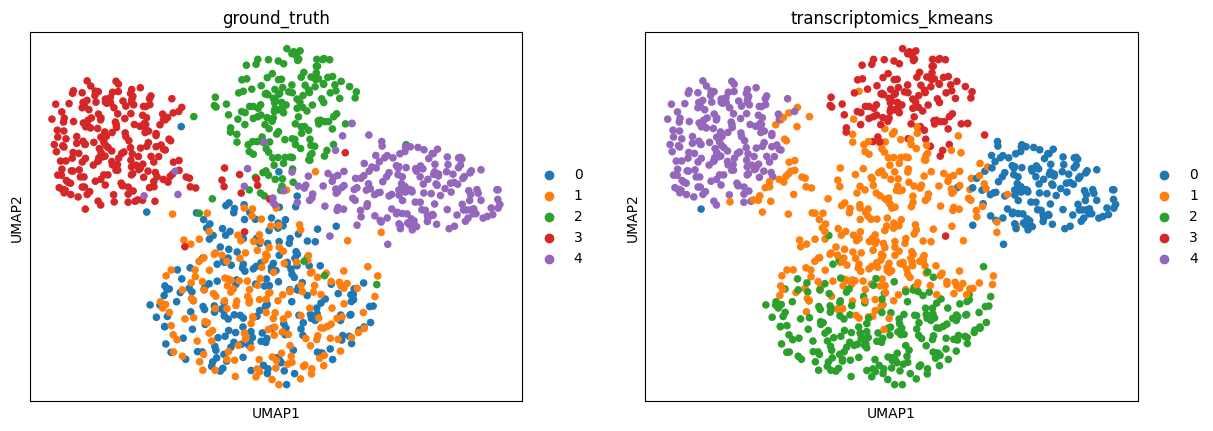

In [8]:
#based only on transcriptomics
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

adata.obs["transcriptomics_kmeans"] = KMeans(5).fit_predict(adata.obsm["X_pca"]).astype(str)
sc.pl.umap(adata, color=["ground_truth", 
                         "transcriptomics_kmeans"])

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


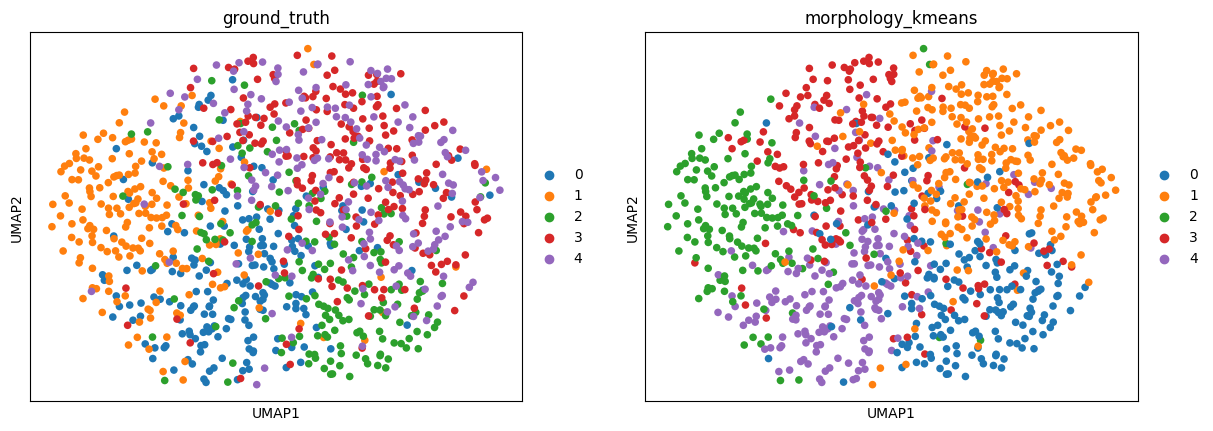

In [9]:
#based only on morphology
sc.pp.neighbors(adata, use_rep="image")
sc.tl.umap(adata)

adata.obs["morphology_kmeans"] = KMeans(5).fit_predict(adata.obsm["image"]).astype(str)
sc.pl.umap(adata, color=["ground_truth", 
                         "morphology_kmeans"])

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


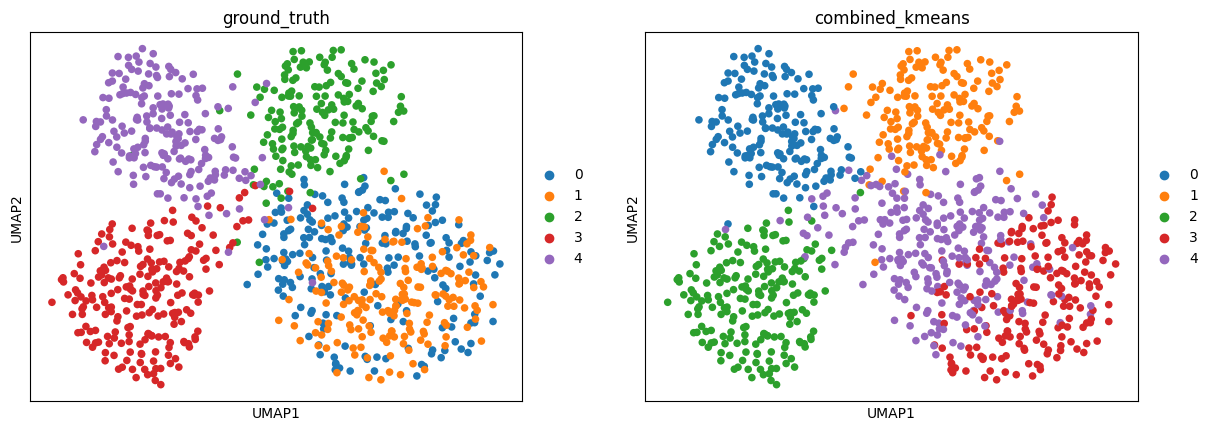

In [10]:
#based only on combined
sc.pp.neighbors(adata, use_rep="combined")
sc.tl.umap(adata)

adata.obs["combined_kmeans"] = KMeans(5).fit_predict(adata.obsm["combined"]).astype(str)
sc.pl.umap(adata, color=["ground_truth", 
                         "combined_kmeans"])

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


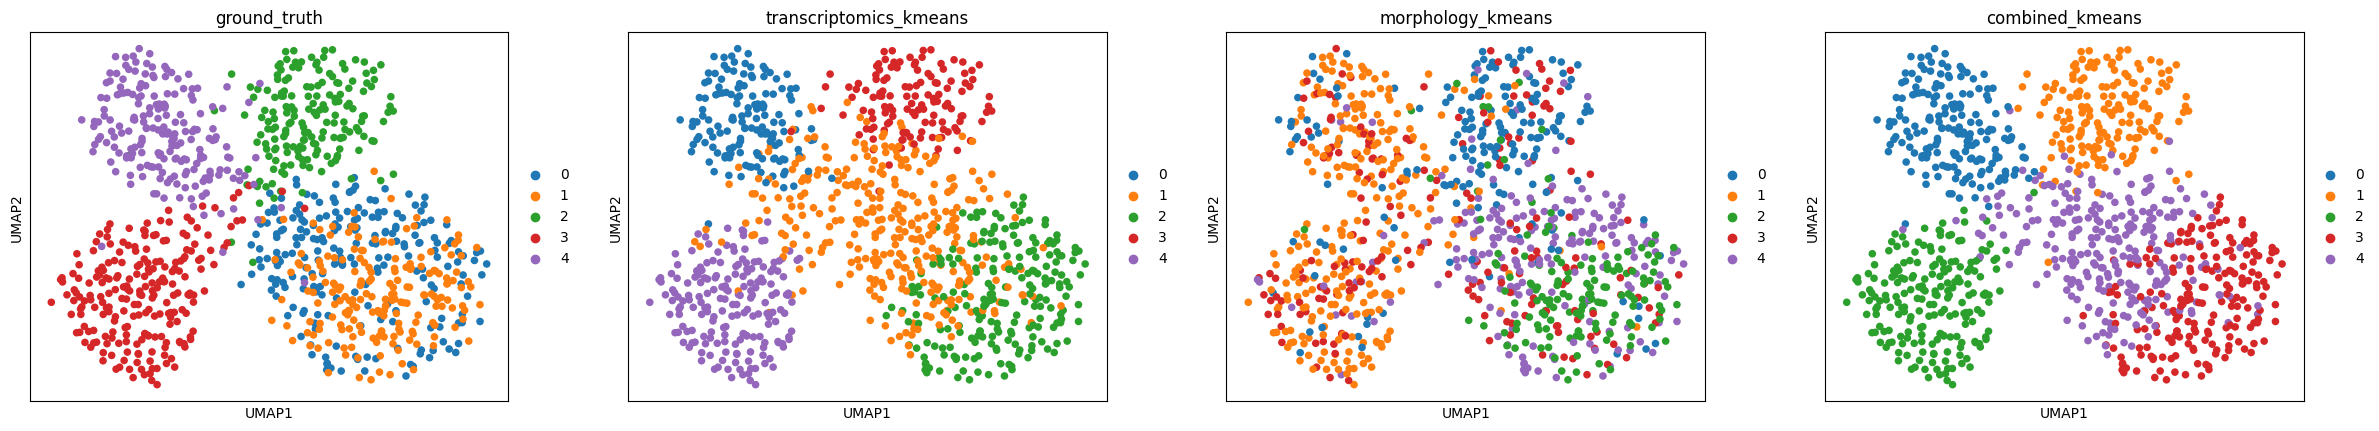

In [11]:
sc.pl.umap(adata, color=["ground_truth", 
                         "transcriptomics_kmeans",
                         "morphology_kmeans",
                         "combined_kmeans"])

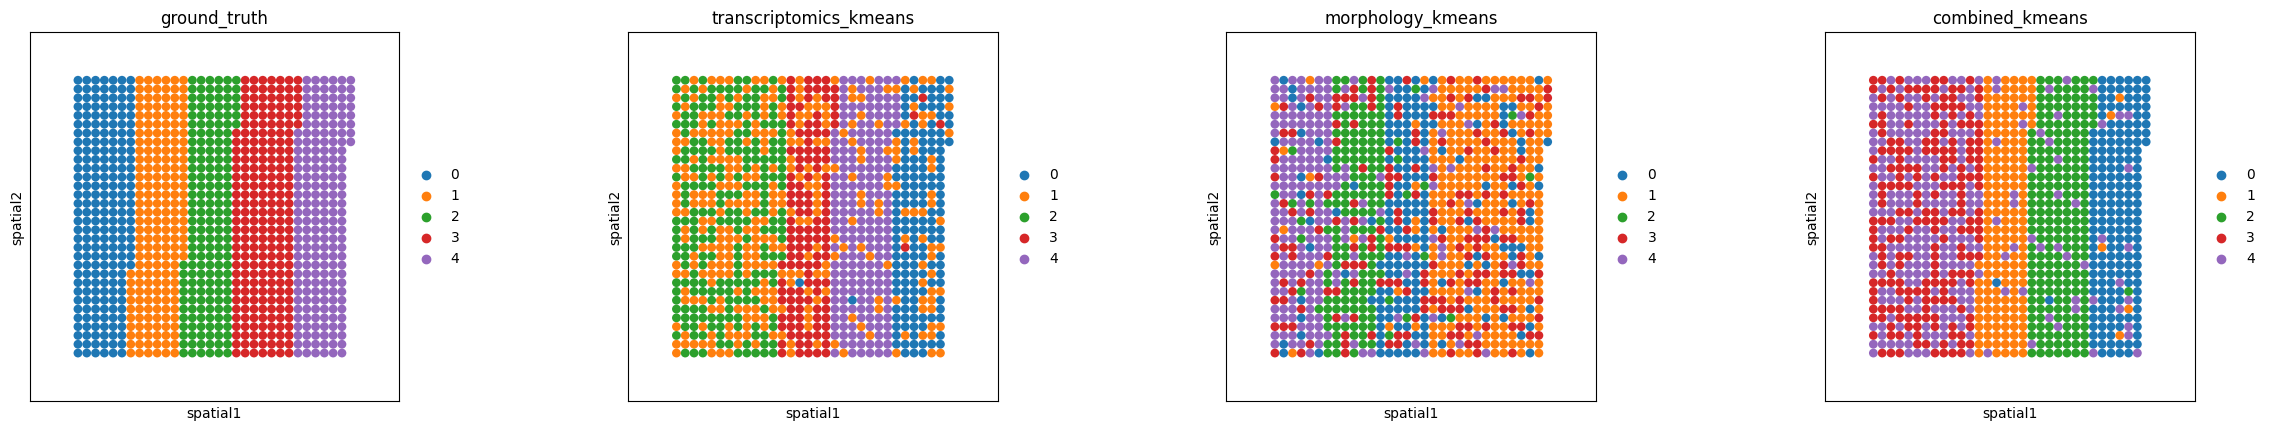

In [12]:
sq.pl.spatial_scatter(adata, color=["ground_truth", 
                         "transcriptomics_kmeans",
                         "morphology_kmeans",
                         "combined_kmeans"], 
                      size=0.5)

### Now, we apply AESTETIK. Please find more infromation about AESTETIK [here](https://github.com/ratschlab/aestetik).

In [13]:
from aestetik import AESTETIK

In [14]:
# we set the transcriptomics modality
adata.obsm["X_pca_transcriptomics"] = adata.obsm["X_pca"][:,0:15]
# we set the morphology modality
adata.obsm["X_pca_morphology"] = adata.obsm["image"][:,0:15]

In [15]:
parameters =    {'morphology_weight': 1.5,
                 'refine_cluster': 1,
                 'window_size': 3,
                 'clustering_method': "kmeans"
                }
parameters

{'morphology_weight': 1.5,
 'refine_cluster': 1,
 'window_size': 3,
 'clustering_method': 'kmeans'}

In [16]:
model = AESTETIK(adata, 
                 nCluster=adata.obs.ground_truth.unique().size,
                 **parameters)

In [17]:
model.prepare_input_for_model()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
# we run the model on CPU here, about 30s.
model.train()

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
model.compute_spot_representations(cluster=True)

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


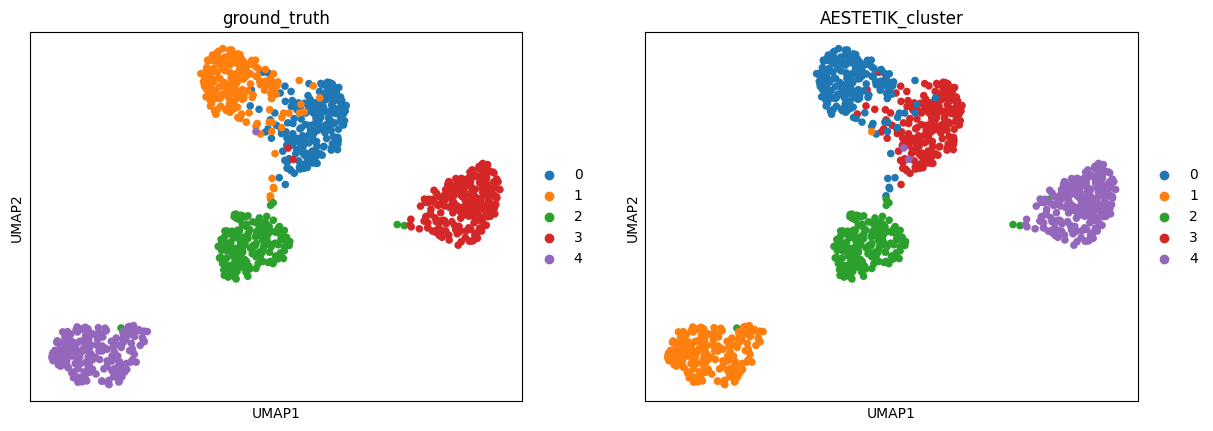

In [20]:
#based on AESTETIK representation
sc.pp.neighbors(model.adata, use_rep="AESTETIK")
sc.tl.umap(model.adata)

sc.pl.umap(adata, color=["ground_truth", 
                         "AESTETIK_cluster"])

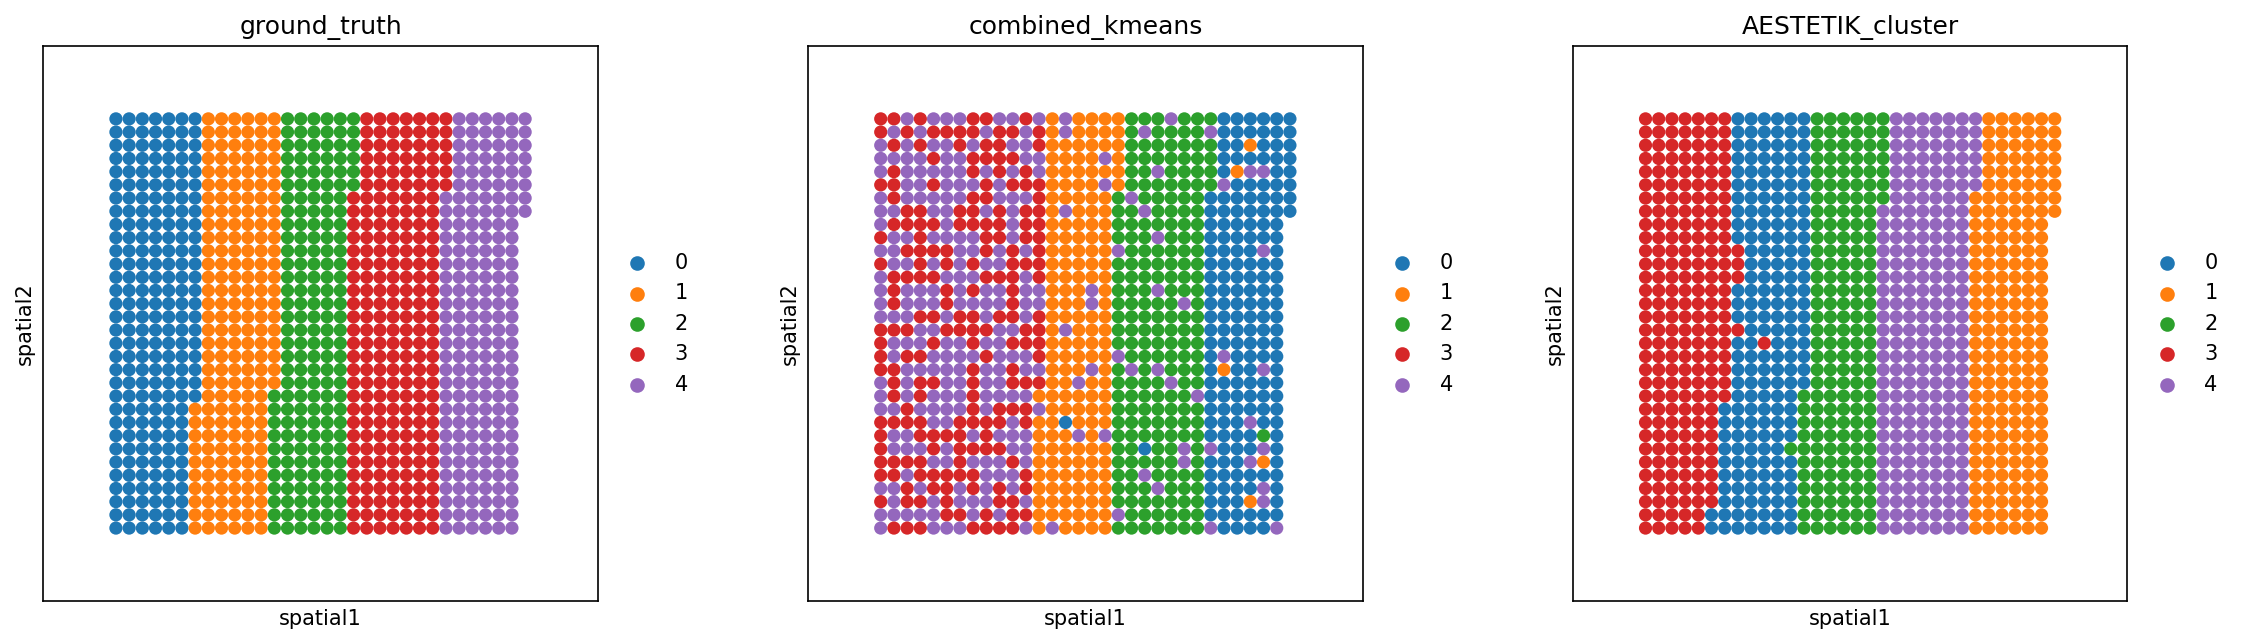

In [21]:
sq.pl.spatial_scatter(adata, color=["ground_truth",
                         "combined_kmeans",
                         "AESTETIK_cluster"], 
                      ncols=5,
                      wspace=0,
                      dpi=150,
                      size=0.5)

Please refer to the original publication for more infromation.

In [22]:
!ls -al example_data/data

total 0
drwxr-s--- 6 knonchev INFK-Raetsch-Collab 4 Jun  4 22:21 .
drwxr-s--- 3 knonchev INFK-Raetsch-Collab 1 Jun  4 22:21 ..
drwxr-s--- 2 knonchev INFK-Raetsch-Collab 2 Jun  4 22:21 h5ad
drwxr-s--- 2 knonchev INFK-Raetsch-Collab 2 Jun  4 22:21 image
drwxr-s--- 2 knonchev INFK-Raetsch-Collab 2 Jun  4 22:21 image_features
drwxr-s--- 2 knonchev INFK-Raetsch-Collab 2 Jun  4 22:21 meta
